# Searching for "a" and "b" values with $\chi^2$ vs median error #

So, here's how this is going down:
1. I'm trying to find $\chi^2$ for each object's light curve .
2. Bin these magnitudes by the median error of the magnitudes (x value)
3. Take the median of each y bin and take the 85\% and 15\% of each bin to find the error of the the y value mentioned below.
4. Will end with x, y, and y_error; try to fit something to this (like $a^2 + b^2$).

Note: if $1/\chi^2$ vs the median error's slope is 2, then b will be 2.

Now, let's define some things to make this easier.

$\chi^2_{reduced} = \frac{\sum{\frac{flux_i - \mu}{\sigma_i^2}}}{n-1}$

n = number of flux observations for that observation

$\sigma_{median, i} = median(\sigma_i)$

x = binning $\sigma_{median, i}$

y = median $\chi^2_{reduced}$ in that bin

$\sigma_y = \frac{percentile(\chi^2_{reduced}, 85) - percentile(\chi^2_{reduced}, 15)}{2\sqrt{n}}$

Finally, I will then be plotting x vs y, with $\sigma_y$ as the error on y.

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import astropy.io.fits as pyfit
from scipy import stats, optimize
np.set_printoptions(precision=5)

In [3]:
#initialize variable
files = ['/home/sam/Documents/Morganson_research/C1_lc.fits', '/home/sam/Documents/Morganson_research/C2_lc.fits'] #,
        # '/home/sam/Documents/Morganson_research/E1_lc.fits', '/home/sam/Documents/Morganson_research/E2_lc.fits', 
        # '/home/sam/Documents/Morganson_research/S1_lc.fits', '/home/sam/Documents/Morganson_research/S2_lc.fits', 
        # '/home/sam/Documents/Morganson_research/X1_lc.fits', '/home/sam/Documents/Morganson_research/X2_lc.fits']

In [ ]:
clip= 10
high_m = 24
low_m = 16
chi_val = []
sigma_med_val = []
sigma_is = []
flux_arr = []

for file in files:
    fits = pyfit.open(file)[1].data
    LC_file = file.split('/')[5][0:2]
    for color in 'GRIZ':
        for fit in fits:
            if (fit['MAG_AUTO_G']- fit['MAG_AUTO_R']) > 0.4:
                if fit['MAG_AUTO_'+color] < high_m:
                    if np.sum(fit["LC_FLUX_PSF_G"] > 0) > 10:
                        if np.abs(fit['SPREAD_MODEL_'+color]) < .003:
                            if fit['MAG_AUTO_'+color] > low_m:
                                fluxes = fit["LC_FLUX_PSF_"+color]
                                fluxes = fluxes[fluxes!=0]
                                mean_flux = fit['MEAN_PSF_'+color]
                                ind_errs = fit['LC_FLUXERR_PSF_'+color]
                                ind_errs = ind_errs[ind_errs!=0]
                                norm_err = (ind_errs/fluxes)
                                chi = np.sum(((fluxes - mean_flux)**2)/(ind_errs**2))/(len(fluxes)-1)
                                if chi > clip:
                                    continue
                                for ind_err in ind_errs:
                                    sigma_is.append(ind_err)
                                for flux in fluxes:
                                    flux_arr.append(flux)
                                chi_val.append(chi)
                                sigma_med_val.append(np.median(norm_err))
                                #err.append(np.median(norm_err)/np.sqrt(len(fluxes)))


        df = pd.DataFrame({'chi2r':chi_val, 'sig_m':sigma_med_val})
        #print(df)

        #m, s = stats.norm.fit(chi_val)
        #print("Regular values " + LC_file + " " +color)
        #print("Mean="+str(m))
        #print("std="+str(s))

        #m, s = stats.norm.fit(np.log10(np.array(chi_val))) # get mean and standard deviation 
        #print("\nLogged values")
        #print("Mean="+str(m))
        #print("std="+str(s))

        #plt.hist((np.array(chi_val)), bins=20)

        #plt.show()

        bins = np.linspace(df.sig_m.min(), df.sig_m.max(), 20)
        groups = df.groupby(pd.cut(df.sig_m, bins))
        #print(groups.size())

        x = np.array(groups.median().sig_m)
        #print(x)
        y = np.array(groups.median().chi2r)
        #print(y)

        #print(groups.chi2r)
        dy = np.array((groups.chi2r.quantile(.85) - groups.chi2r.quantile(.15))/(2*np.sqrt(groups.size())))
        #print(dy)

        j = x[:-1] # sigma
        k = y[:-1] # chi
        dk =dy[:-1]
        plt.figure()
        plt.errorbar(j, k, yerr=dk, label="clipped")
        #plt.errorbar(x, y, yerr=dy, label="all")
        #plt.plot(x[:-3], 0.005**2 + 3*x[:-3]**2)

        z = np.polyfit(j, k, 1)
        #print(z)
        f = np.poly1d(z)

        m = np.polyfit(j, k, 1, w=1/dk)
        #print(m)
        g = np.poly1d(m)

        def test_func(sigma, a, b):
            return a**2/(sigma**1) + b**2

        params, params_covariance = optimize.curve_fit(test_func, j, k, p0=[1, 3], 
                                                       sigma=dk)

        print(LC_file, color, params[0], params[1])

        # calculate new x's and y's
        x_new = np.linspace(j[0], j[-1], 50)
        y_new = f(x_new)
        y_new2 = g(x_new)
        #plt.plot(x_new, y_new, label="no weight "+str(z))
        #plt.plot(x_new, y_new2, label="weighted "+str(m))
        plt.plot(x_new, test_func(x_new, params[0], params[1]), label='a='+str(round(params[0], 4))+'\n'+'b='+str(round(params[1], 4)))
        plt.legend(loc='best')
        #plt.ylim(-5, 10)
        plt.title("Median binned $\sigma_{i}$ vs Median binned $\chi^2_{reduced}$")
        plt.xlabel("median binned $\sigma_i$")
        plt.ylabel("median $\chi^2_{reduced}$ in bin")
        plt.savefig("chi2_clip_"+str(clip)+"_sigma_plot_dy_1_sqrt_n_line_no_last_1_C2.pdf")
        #plt.show()

C1 G 0.07041083189656477 1.1266419555608411


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in square


In [ ]:
a = 0 #params[0]
b = 1 #params[1]

good_fit=0
plt.figure(figsize=(22,12))
X = [ 241, 242, 243, 244, 245, 246, 247, 248  ]
colors = cm.rainbow(np.linspace(0, 1, len(range(17, 25))))
col = 0
for high_m in range(17, 25):
    low_m = high_m - 1
    print("NOW ON TO "+ str(low_m)+" TO "+str(high_m)+"!!!!!")
    flux_dist = []
    for fit in fits:
        if (fit['MAG_AUTO_G']- fit['MAG_AUTO_R']) > 0.4:
            if fit['MAG_AUTO_G'] < high_m:
                if np.sum(fit["LC_FLUX_PSF_G"] > 0) > 10:
                    if np.abs(fit['SPREAD_MODEL_G']) < .003:
                        if fit['MAG_AUTO_G'] > low_m:
                            fluxes = fit["LC_FLUX_PSF_G"]
                            mean_flux = fit['MEAN_PSF_G']
                            ind_errs = fit['LC_FLUXERR_PSF_G']
                            mean_err = fit['MEANERR_PSF_G']
                            for flux, ind_err in zip(fluxes, ind_errs):
                                if flux > 0:
                                    ser = (flux - mean_flux)/np.sqrt(np.abs((a**2)*flux*np.sqrt(np.abs(ind_err**2 - mean_err**2)) + (b**2)*(ind_err**2 - mean_err**2)))
                                    flux_dist.append(ser)


    print(len(flux_dist))
    std1 = 200
    mean = np.mean(np.array(flux_dist))
    std=np.std(np.array(flux_dist))
    while (std1 - std) > 0.00001:
        std1 = std
        flux_dist = [x for x in flux_dist if (x > mean - 3 * std)]
        flux_dist = [x for x in flux_dist if (x < mean + 3 * std)]
        mean = np.mean(np.array(flux_dist))
        std = np.std(np.array(flux_dist))
    stdf = std
    print(stdf)

    plt.subplot(X[col])
    plt.hist(flux_dist, bins=20, normed=True, alpha=0.25, color=colors[col])
    
    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt)  
    lnspc = np.linspace(xmin, xmax, len(flux_dist))

    m, s = stats.norm.fit(flux_dist) # get mean and standard deviation 

    pdf_act =stats.norm.pdf(lnspc, m, s)
    plt.plot(lnspc, pdf_act, label="std="+str(round(s, 4))+"\n"+ str(len(flux_dist))+" fluxes", alpha=1, c=colors[col]) #plotting actual distribution
    good_fit+=np.abs(1-s)
    col = col+1
    pdf_norm = stats.norm.pdf(lnspc, 0, 1)
    plt.plot(lnspc, pdf_norm, label="Norm", c='k') # plot normal distribution
    plt.xlabel("standardized flux")
    plt.title(str(low_m)+" to "+str(high_m) + " G-band Magnitude")
    plt.legend(loc='best')
plt.suptitle("Star flux distribution \n a = "+str(round(a, 4))+"*flux, b="+str(round(b, 4)), fontsize=20, y=.94)
plt.savefig("old_ensemble_chi2_found_a_b_10obs_min_no_last_1_chi.png", bbox_inches='tight')
plt.show()
print(good_fit/8)

NOW ON TO 16 TO 24!!!!!
499610
1.3871592038705227
1.0553069459460362
1.011696016623505
1.0025542864831738
1.0005127865822045
1.0001124204979073
1.000047181287668
1.0000145796257356
1.000006429389991
1.000006429389991


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


NameError: name 'col' is not defined

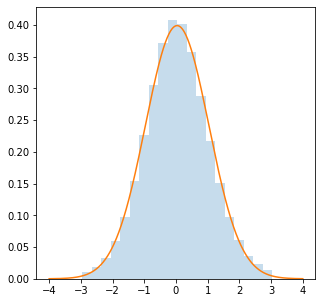

In [7]:
a = params[0]
b = params[1]
plt.figure(figsize=(5,5))
for high_m in range(24, 25):
    low_m = 16
    print("NOW ON TO "+ str(low_m)+" TO "+str(high_m)+"!!!!!")
    flux_dist = []
    for fit in fits:
        if (fit['MAG_AUTO_G']- fit['MAG_AUTO_R']) > 0.4:
            if fit['MAG_AUTO_G'] < high_m:
                if np.sum(fit["LC_FLUX_PSF_G"] > 0) > 10:
                    if np.abs(fit['SPREAD_MODEL_G']) < .003:
                        if fit['MAG_AUTO_G'] > low_m:
                            fluxes = fit["LC_FLUX_PSF_G"]
                            mean_flux = fit['MEAN_PSF_G']
                            ind_errs = fit['LC_FLUXERR_PSF_G']
                            mean_err = fit['MEANERR_PSF_G']
                            for flux, ind_err in zip(fluxes, ind_errs):
                                if flux > 0:
                                    ser = (flux - mean_flux)/np.sqrt(np.abs((a**2)*flux*np.sqrt(np.abs(ind_err**2 - mean_err**2)) + (b**2)*(ind_err**2 - mean_err**2)))
                                    flux_dist.append(ser)


print(len(flux_dist))
std1 = 200
mean = np.mean(np.array(flux_dist))
std=np.std(np.array(flux_dist))
print(std)
while (std1 - std) > 0.00001:
    std1 = std
    flux_dist = [x for x in flux_dist if (x > mean - 3 * std)]
    flux_dist = [x for x in flux_dist if (x < mean + 3 * std)]
    mean = np.mean(np.array(flux_dist))
    std = np.std(np.array(flux_dist))
    print(std)
stdf = std
print(stdf)

plt.hist(flux_dist, bins=20, normed=True, alpha=0.25)

xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(flux_dist))

m, s = stats.norm.fit(flux_dist) # get mean and standard deviation 

pdf_act =stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_act, label="std="+str(round(s, 4))+"\n"+ str(len(flux_dist))+" fluxes", alpha=1) #plotting actual distribution
col = col+1
pdf_norm = stats.norm.pdf(lnspc, 0, 1)
plt.plot(lnspc, pdf_norm, label="Norm", c='k') # plot normal distribution
plt.xlabel("standardized flux")
plt.title("Star flux distribution \n a = "+str(round(a, 4))+"*flux, b="+str(round(b, 4))+ '\n' + str(low_m)+" to "+str(high_m) + " G-band Magnitude")
plt.legend(loc='best')
plt.savefig(str(low_m)+'_'+str(high_m)+"chi2_found_a_b_no_last_1_chi.pdf")
plt.show()

In [3]:
import itertools as it

color_iter = it.cycle([0, 1, 2, 3])
for i in range(10):
    #col = next(color_iter)
    print(next(color_iter))

0
1
2
3
0
1
2
3
0
1
